<a href="https://colab.research.google.com/github/ikabrain/UCS761-Deep-Learning-Lab/blob/main/DL_assign4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - Multilayer perceptron: Implement backpropagation. Predict the age of abalone from physical measurements.

---


In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo

In [3]:
RNG = 42
np.random.seed(RNG)

## Import dataset

---

Link for dataset: https://archive.ics.uci.edu/dataset/1/abalone

In [4]:
# Fetch dataset
abalone = fetch_ucirepo(id=1)

# Data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# Concatenate dataframes
df = pd.concat([X, y], axis=1)
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
df.shape

(4177, 9)

In [6]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


### Analysing Distribution


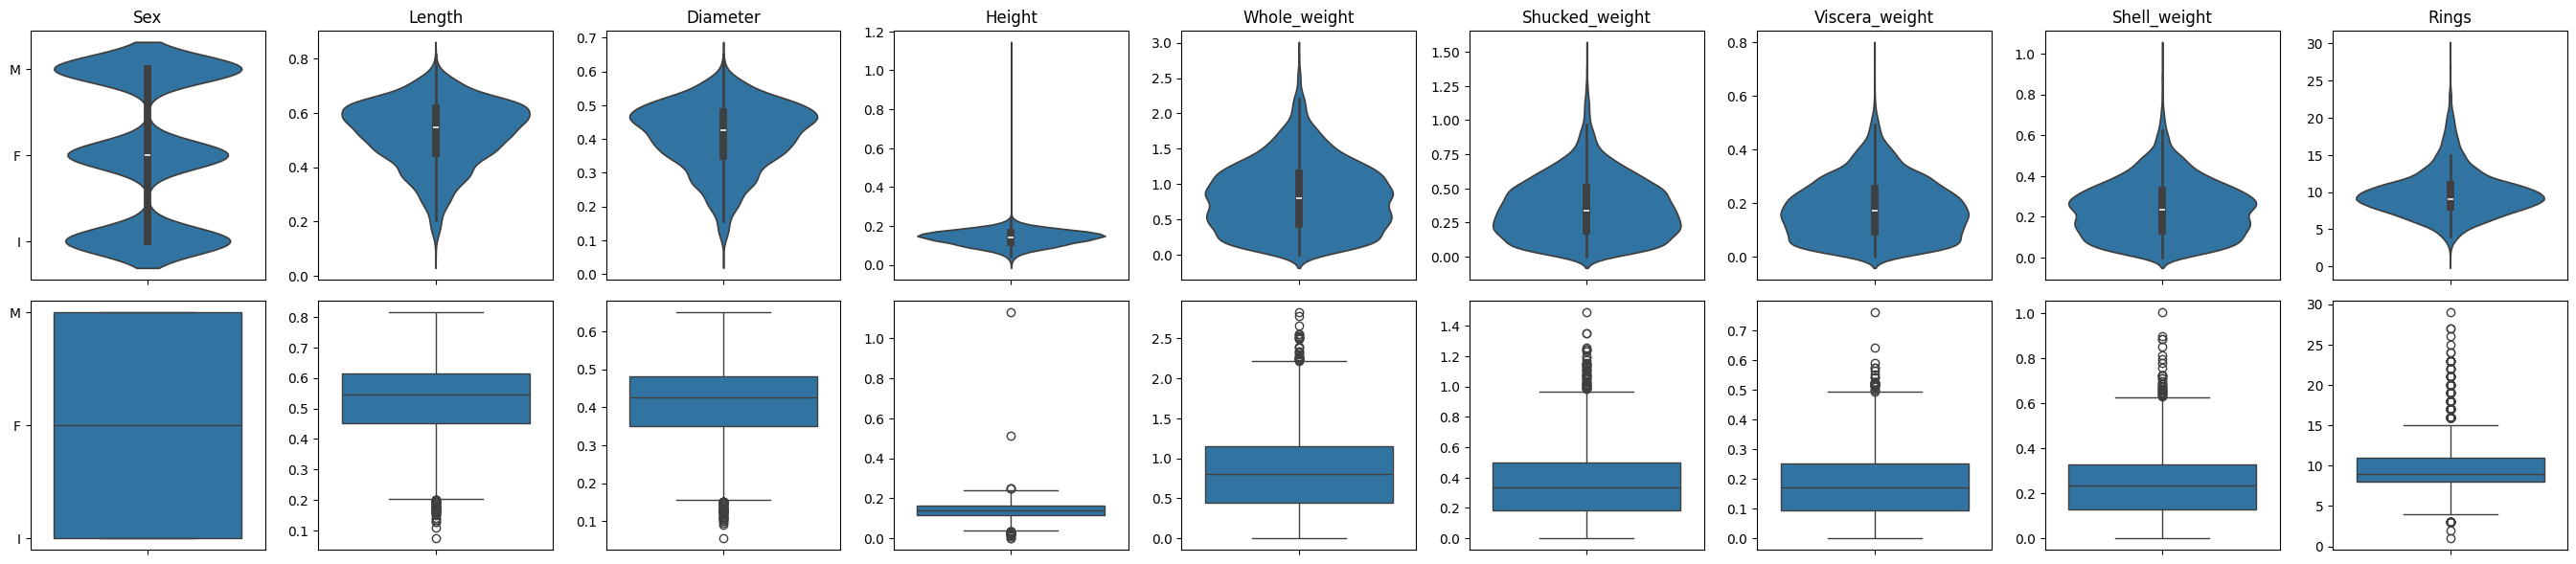

In [8]:
n_cols = df.shape[1]  # Number of rows for subplots

plt.figure(figsize=(3 * n_cols, 6))

for i, feature in enumerate(df.columns):
    plt.subplot(2, n_cols, i + 1)
    sns.violinplot(y=df[feature])
    plt.title(feature)
    plt.ylabel('') # Remove y-axis label to avoid clutter

    plt.subplot(2, n_cols, n_cols + i + 1)
    sns.boxplot(y=df[feature])
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [9]:
df_numeric = df.select_dtypes("number").columns
print(df_numeric)

Index(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


In [10]:
df_numeric_pred = df_numeric.drop("Rings")
print(df_numeric_pred)

Index(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight'],
      dtype='object')


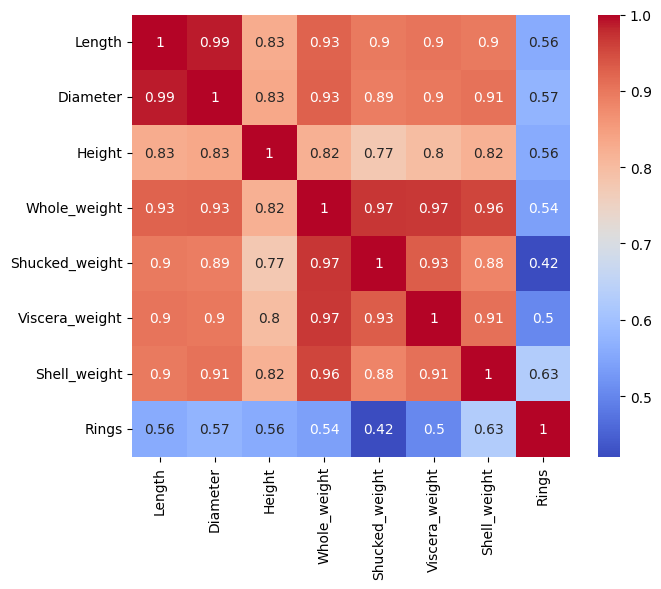

In [11]:
plt.figure(figsize=(7, 6))
sns.heatmap(df[df_numeric].corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

### Data Encoding

In [12]:
# One-Hot Encoding 'sex' column
df_temp = pd.get_dummies(df, columns=['Sex'], dtype=float)
df_temp.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.0,1.0,0.0


In [13]:
temp_cols = ["Sex_M", "Sex_F"] + [c for c in df_temp.columns if not c.startswith('Sex_')]
df_encoded = df_temp[temp_cols]
df_encoded.head()

,Sex_M,Sex_F,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,1.0,0.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1.0,0.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.0,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1.0,0.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Splitting & stratifying data

In [14]:
# 1. Create bins for stratification
# This ensures even the rare 'old' or 'very young' abalones are distributed

ring_bins = pd.cut(df_encoded['Rings'], bins=5, labels=False)
ring_bins.head()

,Rings
0,2
1,1
2,1
3,1
4,1


In [15]:
# 2. Perform stratified split
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Rings', axis=1)
y = df_encoded['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=ring_bins, random_state=RNG)

print(f"Training data: {X_train.shape[0]:6,d}")
print(f" Testing data: {X_test.shape[0]:6,d}")

Training data:  3,341
 Testing data:    836


### Scaling Predictors

In [16]:
# Standardizing variables as they exhibit Gaussian symmetries
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
X_train[df_numeric_pred] = ssc.fit_transform(X_train[df_numeric_pred])
X_test[df_numeric_pred] = ssc.transform(X_test[df_numeric_pred])

In [17]:
X_train.head()

,Sex_M,Sex_F,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
249,0.0,0.0,-1.506560,-1.402212,-0.704820,-1.262679,-1.261544,-1.159220,-1.219273
1666,0.0,1.0,0.670234,0.620603,0.351041,0.289633,0.147462,0.389372,0.680152
1589,0.0,0.0,-0.041410,0.013759,0.116405,-0.379872,-0.289737,-0.199916,-0.537060
1927,1.0,0.0,0.753957,0.620603,0.233723,0.521306,0.620906,0.928409,0.206193
3398,1.0,0.0,-1.339114,-1.250501,-1.291410,-1.248390,-1.245687,-1.186629,-1.219273


## TODO: Designing Multilayer perceptron from scratch

---


For regression, the perceptron only needs to have an identity function for activation.

Now, we use MSE loss

$$
    \text{Mean Square Error} \quad MSE(y, \hat{y}) = \frac{1}{n}(y^{T}y - 2y^{T}\hat{y} + \hat{y}^{T}\hat{y})
$$

$$
    \Rightarrow
    \mathcal{L}_\beta(y, \hat{y}) = \frac{1}{n}(y^{T}y - 2y^{T}\hat{y} + \hat{y}^{T}\hat{y})
$$

Taking derivative, we get
$$
    \frac{\partial\mathcal{L}}{\partial\beta}(y, \hat{y}) = -X^{T}y + X^{T}(X\beta + \beta_0) = -X^{T}(y - \hat{y})
$$
$$
    \text{and} \quad \frac{\partial\mathcal{L}}{\partial\beta_0}(y, \hat{y}) = -\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})
$$

In [ ]:
class PerceptronLayer:
    def __init__(self, lr=0.1, n_iter=1000):
        self.lr = lr
        self.epochs = n_iter
        self.weights = None
        self.bias = None
        self.trained = False

    def _initialize_weights(self, n_features):
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()
        return self.weights, self.bias

    def _get_linear(self, X, weights, bias):
        return np.dot(X, weights) + bias

    def _relu(self, z):
        """ReLU activation function"""
        z = np.ndarray(z)
        return np.max(0, z)

    def predict(self, X):
        """
        One forward pass with samples in X
        """
        z = self._get_linear(X, self.weights, self.bias)
        return self._relu(z)

    def _mse_loss(self, y_true, y_pred):
        """Return the mean square error between matrices y_true and y_pred"""
        return np.mean((y_true - y_pred) ** 2)

    def _update_weights(self, input, error_vals):
        """Updates weights of the Linear Perceptron using gradients"""
        self.weights += self.lr * np.dot(input, error_vals)
        self.bias += self.lr * np.sum(error_vals)
        return (self.weights, self.bias)

    def fit(self, X, y):
        # 1. Initialize weights and bias
        n_samples, n_feat = X.shape
        self._initialize_weights(n_feat)

        for epoch in range(self.epochs):
            for sample_idx, sample in enumerate(X):
                # 2. Calculate linear output
                y_pred = self.predict(sample)

                # 3. Update weights and bias using gradients
                error = y[sample_idx] - y_pred
                self._update_weights(sample, error)

            if epoch % 10 == 0:
                full_predictions = self.predict(X)
                loss = self._mse_loss(y, full_predictions)
                print(f"Epoch {epoch}/{self.epochs}: Loss = {loss:.4f}")

        self.trained = True
        return self

    def __repr__(self):
        return f"LinearPerceptron(lr={self.lr}, n_iter={self.epochs}, trained={self.trained})"

## Using MLP on dataset

---

In [ ]:
%%time
p = LinearPerceptron(lr=0.01, n_iter=100)
p.fit(X_train, y_train)

Epoch 0/100: Loss = 1347283526.5389
Epoch 10/100: Loss = 55704216.8423
Epoch 20/100: Loss = 4327173.2012
Epoch 30/100: Loss = 1929007.5804
Epoch 40/100: Loss = 1762133.2955
Epoch 50/100: Loss = 1742966.2671
Epoch 60/100: Loss = 1740194.2953
Epoch 70/100: Loss = 1739823.6730
Epoch 80/100: Loss = 1739803.3293
Epoch 90/100: Loss = 1739818.5510
CPU times: user 32 ms, sys: 208 µs, total: 32.2 ms
Wall time: 57.1 ms


LinearPerceptron(lr=0.01, n_iter=100, trained=True)

In [ ]:
y_pred = p.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2*100:.2f}%")

R2 score: 94.01%


In [ ]:
# Testing on first row
print(f"Values of first record: {X[0]}")
print(f"Actual target: {y[0]:.2f}")
print(f"Predicted target: {p.predict(X[0]):.2f}")

Values of first record: [25  1]
Actual target: 30450.00
Predicted target: 28867.43
